Quantum Classifier 

This notebook contains the final implementation of the quantum classifier used in this project.
It is intentionally kept as one executable cell to preserve reproducibility and avoid accidental changes.

What the cell does (high level)
	1.	Loads engineered PLAsTiCC features (binary task: SNIa vs SNII)
Uses a precomputed feature table extracted from light curves.
	2.	Splits data into train/test first 
The train/test split happens before any feature selection or preprocessing decisions.
	3.	Automatically selects the top 3 features (TRAIN only)
	•	Computes point-biserial correlation between each candidate feature and the label using the training set only
	•	Selects the top 3 by |correlation|
	•	This aligns with the 3-qubit input constraint (1 feature per qubit)
	4.	Fits preprocessing on TRAIN only, applies to TEST
	•	Cleans NaN/Inf defensively
	•	Clips outliers using training-set 1st–99th percentiles (then applies the same bounds to test)
	•	Applies an optional log transform only if training-set dynamic range is large (and applies the same transform to test)
This prevents extreme values from collapsing angle encoding.
	5.	Encodes features as quantum rotation angles
Uses MinMax scaling (fit on TRAIN) to map values into [0, π] for valid angle encoding.
	6.	Builds a 3-qubit variational quantum circuit
	•	Feature map: ZZFeatureMap (entangling feature encoding)
	•	Ansatz: TwoLocal (trainable variational layers)
	•	Combined into one parameterized circuit used by EstimatorQNN
	7.	Trains the quantum classifier (noiseless simulation)
	•	Backend: StatevectorEstimator (V2 primitive) → noiseless statevector simulation
	•	Optimizer: COBYLA (gradient-free) for a fixed number of iterations
	8.	Evaluates performance + selects a decision threshold (from TRAIN)
	•	Produces probability-like scores via predict_proba()
	•	Optionally chooses a classification threshold using TRAIN scores to maximize balanced accuracy, then applies it to TEST
	•	Reports: accuracy, AUC, balanced accuracy, confusion matrix, classification report, ROC curve
	•	Saves results to JSON for comparison with classical baselines

Note: This notebook is designed to provide a clean, comparable baseline rather than exhaustive hyperparameter tuning. The goal is to understand when QML is competitive and when classical ML remains more effective.

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Quantum ML — PLAsTiCC (EstimatorQNN) | Leakage-safe + V2 primitive
FEATURES_PATH: ../data/plasticc/transient_features.csv
RESULTS_DIR: ../results

Loaded samples: 1072
Label distribution:
 label
SNII    549
SNIa    523
Name: count, dtype: int64

X_full shape: (1072, 16)

Train full: (857, 16) Test full: (215, 16)
Train label counts: {np.int64(0): np.int64(439), np.int64(1): np.int64(418)}
Test  label counts: {np.int64(0): np.int64(110), np.int64(1): np.int64(105)}

Top 10 by |correlation| (TRAIN only):
           feature  abs_corr  signed_corr      p_value
         time_span  0.279160    -0.279160 8.329884e-17
      decline_time  0.265730    -0.265730 2.565207e-15
           mag_max  0.160794     0.160794 2.232677e-06
           mag_std  0.150796     0.150796 9.275654e-06
          mag_mean  0.126317     0.126317 2.094389e-04
         mag_range  0.123106     0.123106 3.034252e-04
         rise_time  0.104246    -0.104246 2.245916e-03
mean_decline_slope  0.068830     0.068830 4.396452e-

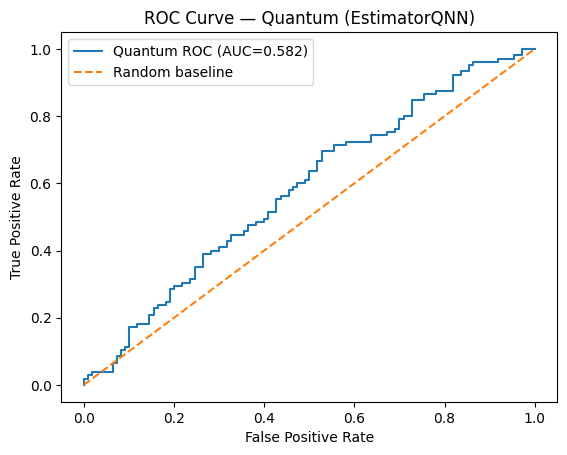


Saved results to: ../results/plasticc_quantum_results_final.json


In [5]:
# ============================================================
# 03_quantum_classifier.ipynb
# ============================================================

import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

from scipy.stats import pointbiserialr

# Qiskit / QML
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import StatevectorEstimator  # V2 primitive (no deprecation warning)

# Optimizer import: try QML optimizer first, fall back if needed
try:
    from qiskit_machine_learning.optimizers import COBYLA
except Exception:
    from qiskit_algorithms.optimizers import COBYLA

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit import QuantumCircuit


# -----------------------------
# 0) Config
# -----------------------------
DATA_DIR = os.path.join("..", "data", "plasticc")
FEATURES_PATH = os.path.join(DATA_DIR, "transient_features.csv")

RESULTS_DIR = os.path.join("..", "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.2

OUT_JSON = os.path.join(RESULTS_DIR, "plasticc_quantum_results_final.json")

# If True: choose decision threshold using TRAIN scores to maximize balanced accuracy
USE_TRAIN_OPTIMAL_THRESHOLD = True

# Threshold grid to search (only used if USE_TRAIN_OPTIMAL_THRESHOLD=True)
THRESHOLDS = np.linspace(0.05, 0.95, 19)


print("=" * 70)
print("Quantum ML — PLAsTiCC (EstimatorQNN) | Leakage-safe + V2 primitive")
print("=" * 70)
print("FEATURES_PATH:", FEATURES_PATH)
print("RESULTS_DIR:", RESULTS_DIR)


# -----------------------------
# 1) Load data
# -----------------------------
features_df = pd.read_csv(FEATURES_PATH)
print("\nLoaded samples:", len(features_df))
print("Label distribution:\n", features_df["label"].value_counts())

label_map = {"SNII": 0, "SNIa": 1}
y = features_df["label"].map(label_map).values
if np.any(pd.isnull(y)):
    bad = features_df.loc[pd.isnull(y), "label"].unique()
    raise ValueError(f"Unknown labels found: {bad}")

# -----------------------------
# 2) Define engineered feature columns (expected)
# -----------------------------
feature_cols = [
    "mag_min", "mag_max", "mag_mean", "mag_std", "mag_range",
    "flux_max", "flux_mean", "flux_std",
    "time_span", "rise_time", "decline_time", "rise_decline_ratio",
    "mean_rise_slope", "mean_decline_slope", "max_slope",
    "n_points"
]

missing = [c for c in feature_cols if c not in features_df.columns]
if missing:
    raise ValueError(f"Missing expected features in CSV: {missing}")

X_full = features_df[feature_cols].values
print("\nX_full shape:", X_full.shape)


# ============================================================
# IMPORTANT FIX: Split FIRST to avoid leakage
# ============================================================
# -----------------------------
# 3) Train/test split FIRST (no leakage)
# -----------------------------
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nTrain full:", X_train_full.shape, "Test full:", X_test_full.shape)
print("Train label counts:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test  label counts:", dict(zip(*np.unique(y_test, return_counts=True))))


# -----------------------------
# 4) Auto-select top 3 features using TRAIN ONLY
# -----------------------------
correlations = []
for i, feat in enumerate(feature_cols):
    corr, pval = pointbiserialr(y_train, X_train_full[:, i])
    correlations.append({
        "feature": feat,
        "abs_corr": float(abs(corr)),
        "signed_corr": float(corr),
        "p_value": float(pval),
    })

corr_df = pd.DataFrame(correlations).sort_values("abs_corr", ascending=False)
selected_features = corr_df.head(3)["feature"].tolist()
selected_idx = [feature_cols.index(f) for f in selected_features]

print("\nTop 10 by |correlation| (TRAIN only):")
print(corr_df.head(10).to_string(index=False))
print("\nSelected features (3 qubits):", selected_features)


def separation_sigma(feature_values, y_binary):
    a = feature_values[y_binary == 1]  # SNIa
    b = feature_values[y_binary == 0]  # SNII
    sep = abs(a.mean() - b.mean())
    denom = b.std() if b.std() > 0 else 1e-12
    return float(sep / denom), float(a.mean()), float(a.std()), float(b.mean()), float(b.std())


print("\nClass separability (rough σ units) — computed on FULL dataset for interpretability:")
# (Interpretability only; doesn't affect training. If you want strictly train-only reporting, swap y->y_train and use train values.)
for feat in selected_features:
    vals = features_df[feat].values
    sep_sigma, a_mu, a_sd, b_mu, b_sd = separation_sigma(vals, y)
    print(f"  {feat:<18} {sep_sigma:>5.2f}σ   | SNIa μ={a_mu:.3f} σ={a_sd:.3f} | SNII μ={b_mu:.3f} σ={b_sd:.3f}")


# Build X_train/X_test with selected features
X_train = X_train_full[:, selected_idx].copy()
X_test  = X_test_full[:,  selected_idx].copy()


# -----------------------------
# 5) Preprocessing fit on TRAIN only, apply to TEST
#    - NaN/Inf clean
#    - clip p1/p99 from TRAIN
#    - decide log-transform from TRAIN
# -----------------------------
def clean_clip_log_fit_transform(X_tr, X_te, feature_names):
    # Clean NaN/Inf
    if np.any(np.isnan(X_tr)) or np.any(np.isinf(X_tr)):
        print("\n⚠️ Found NaN/Inf in TRAIN — cleaning with nan_to_num.")
        X_tr = np.nan_to_num(X_tr, nan=0.0, posinf=1e10, neginf=-1e10)

    if np.any(np.isnan(X_te)) or np.any(np.isinf(X_te)):
        print("\n⚠️ Found NaN/Inf in TEST — cleaning with nan_to_num.")
        X_te = np.nan_to_num(X_te, nan=0.0, posinf=1e10, neginf=-1e10)

    X_tr2 = X_tr.copy()
    X_te2 = X_te.copy()

    clip_bounds = []
    log_transformed = []
    log_shifts = {}

    for j in range(X_tr2.shape[1]):
        # Clip bounds from TRAIN only
        p1, p99 = np.percentile(X_tr2[:, j], [1, 99])
        X_tr2[:, j] = np.clip(X_tr2[:, j], p1, p99)
        X_te2[:, j] = np.clip(X_te2[:, j], p1, p99)
        clip_bounds.append((float(p1), float(p99)))

        # Decide log-transform from TRAIN only
        fmin, fmax = X_tr2[:, j].min(), X_tr2[:, j].max()
        dynamic_range = (fmax - fmin) / (abs(fmin) + 1e-10)

        if dynamic_range > 100:
            shift = float(X_tr2[:, j].min())  # TRAIN-only shift
            X_tr2[:, j] = np.log1p(X_tr2[:, j] - shift + 1)
            X_te2[:, j] = np.log1p(X_te2[:, j] - shift + 1)
            log_transformed.append(feature_names[j])
            log_shifts[feature_names[j]] = shift

    return X_tr2, X_te2, clip_bounds, log_transformed, log_shifts


X_train_proc, X_test_proc, clip_bounds, log_transformed, log_shifts = clean_clip_log_fit_transform(
    X_train, X_test, selected_features
)

print("\nClip bounds (TRAIN p1, p99) per feature:")
for feat, (p1, p99) in zip(selected_features, clip_bounds):
    print(f"  {feat}: [{p1:.4f}, {p99:.4f}]")

print("Log-transformed features:", log_transformed if log_transformed else "None")
if log_transformed:
    print("Log shifts (TRAIN min after clipping):", log_shifts)


# -----------------------------
# 6) Scale to quantum angles [0, π] using TRAIN fit only
# -----------------------------
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train_angles = scaler.fit_transform(X_train_proc)
X_test_angles  = scaler.transform(X_test_proc)

print("\nAngle stats (train):")
print("  min:   ", X_train_angles.min(axis=0))
print("  max:   ", X_train_angles.max(axis=0))
print("  mean:  ", X_train_angles.mean(axis=0))
print("  median:", np.median(X_train_angles, axis=0))


# -----------------------------
# 7) Build quantum circuit (feature map + ansatz)
# -----------------------------
num_qubits = X_train_angles.shape[1]

feature_map = ZZFeatureMap(
    feature_dimension=num_qubits,
    reps=2,
    entanglement="full"
)

ansatz = TwoLocal(
    num_qubits=num_qubits,
    reps=3,
    rotation_blocks=["ry", "rz"],
    entanglement_blocks="cz",
    entanglement="full"
)

circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)

print("\nCircuit summary:")
print("  qubits:          ", num_qubits)
print("  depth (raw):     ", circuit.depth())
print("  depth (decomp):  ", circuit.decompose().depth())
print("  total params:    ", circuit.num_parameters)
print("  input params:    ", len(list(feature_map.parameters)))
print("  trainable params:", len(list(ansatz.parameters)))
print("  ops:", circuit.count_ops())


# -----------------------------
# 8) Create QNN + classifier (V2 primitive)
# -----------------------------
estimator = StatevectorEstimator()

qnn = EstimatorQNN(
    estimator=estimator,
    circuit=circuit,
    input_params=list(feature_map.parameters),
    weight_params=list(ansatz.parameters),
)

optimizer = COBYLA(maxiter=300)

q_clf = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=optimizer,
    one_hot=False,
)


# -----------------------------
# 9) Train
# -----------------------------
print("\nTraining… (COBYLA maxiter=300)")
start = time.time()
q_clf.fit(X_train_angles, y_train)
training_time = time.time() - start
print(f"✓ Training time: {training_time/60:.1f} min")


# -----------------------------
# 10) Evaluate + ROC curve
# -----------------------------
def get_scores_from_predict_proba(model, X):
    """Return a 1D score array where larger => more likely class 1."""
    proba = model.predict_proba(X)
    # Common cases:
    # - (n,2): [P(class0), P(class1)]
    # - (n,1) or (n,): some QML configs return a single score
    if proba.ndim == 2 and proba.shape[1] == 2:
        return proba[:, 1]
    return proba.ravel()


scores_test = get_scores_from_predict_proba(q_clf, X_test_angles)
scores_train = get_scores_from_predict_proba(q_clf, X_train_angles)

# Pick threshold
if USE_TRAIN_OPTIMAL_THRESHOLD:
    best_t, best_bal = 0.5, -1
    for t in THRESHOLDS:
        pred_tr = (scores_train >= t).astype(int)
        cm_tr = confusion_matrix(y_train, pred_tr, labels=[0, 1])
        tn, fp, fn, tp = cm_tr.ravel()
        sens = tp / (tp + fn) if (tp + fn) else 0.0
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        bal = 0.5 * (sens + spec)
        if bal > best_bal:
            best_bal, best_t = bal, t

    threshold = float(best_t)
    print(f"\nChosen threshold (from TRAIN): {threshold:.2f} | train balanced acc: {best_bal:.3f}")
else:
    threshold = 0.5
    print("\nUsing default threshold = 0.50")

y_pred = (scores_test >= threshold).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, scores_test)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) else 0.0  # SNIa recall
specificity = tn / (tn + fp) if (tn + fp) else 0.0  # SNII recall
balanced_acc = 0.5 * (sensitivity + specificity)

print("\n" + "=" * 70)
print("RESULTS")
print("=" * 70)
print(f"Accuracy:          {acc:.3f}")
print(f"AUC:               {auc:.3f}")
print(f"Balanced accuracy: {balanced_acc:.3f}")
print(f"Sensitivity SNIa:  {sensitivity:.3f}")
print(f"Specificity SNII:  {specificity:.3f}")
print(f"Decision threshold:{threshold:.2f}")

print("\nConfusion matrix [SNII, SNIa]:")
print(cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["SNII", "SNIa"], zero_division=0))

# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, scores_test)
plt.figure()
plt.plot(fpr, tpr, label=f"Quantum ROC (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Quantum (EstimatorQNN)")
plt.legend()
plt.show()


# -----------------------------
# 11) Save results JSON
# -----------------------------
results = {
    "dataset_size": int(len(features_df)),
    "train_size": int(len(X_train_angles)),
    "test_size": int(len(X_test_angles)),
    "model": "EstimatorQNN",
    "features_selected_auto": selected_features,
    "feature_selection_method": "top3_by_abs_pointbiserial_correlation_on_train_only",
    "preprocessing": {
        "order": "split -> select_features(train) -> fit_preproc(train) -> apply(test)",
        "outlier_clipping": "1st/99th percentile (fit on TRAIN)",
        "clip_bounds": {
            feat: {"p1": float(p1), "p99": float(p99)}
            for feat, (p1, p99) in zip(selected_features, clip_bounds)
        },
        "log_transformed_features": log_transformed,
        "log_shifts_train": log_shifts,
        "angle_scaling": "[0, pi] via MinMaxScaler (fit on TRAIN)",
    },
    "circuit": {
        "qubits": int(num_qubits),
        "feature_map": {"type": "ZZFeatureMap", "reps": 2, "entanglement": "full"},
        "ansatz": {"type": "TwoLocal", "reps": 3, "rotations": ["ry", "rz"], "entanglement_gate": "cz", "entanglement": "full"},
        "depth_raw": int(circuit.depth()),
        "depth_decomposed": int(circuit.decompose().depth()),
        "total_params": int(circuit.num_parameters),
        "trainable_params": int(len(list(ansatz.parameters))),
        "ops": {k: int(v) for k, v in circuit.count_ops().items()},
    },
    "optimizer": {"type": "COBYLA", "maxiter": 300},
    "training_time_seconds": float(training_time),
    "inference": {
        "thresholding": "train-optimized" if USE_TRAIN_OPTIMAL_THRESHOLD else "fixed_0.5",
        "threshold_grid": THRESHOLDS.tolist() if USE_TRAIN_OPTIMAL_THRESHOLD else None,
        "chosen_threshold": float(threshold),
    },
    "metrics": {
        "accuracy": float(acc),
        "auc": float(auc),
        "balanced_accuracy": float(balanced_acc),
        "sensitivity_snia": float(sensitivity),
        "specificity_snii": float(specificity),
        "confusion_matrix": cm.tolist(),
    },
}

with open(OUT_JSON, "w") as f:
    json.dump(results, f, indent=2)

print("\nSaved results to:", OUT_JSON)